In [1]:
import chess
import chess.polyglot
import tensorflow as tf
import numpy as np
import sys
sys.path.append("C:/Users/king pc/Desktop/code pfe/code")
import format_bitmap_plus as fm
from tensorflow import keras



In [2]:
PLUS_INFINITY = 2
MINUS_INFINITY = -1
WHITE_WINS_VALUE = 1
BLACK_WINS_VALUE = 0
DRAW_VALUE = 0.5

In [3]:
class Engine:
    

    def __init__(self, model, shape_board_fun):
        self.model = model
        self.shape_board_fun = shape_board_fun
        self.nodes = 0


    def shape_board(self, board):
        """
        make the board in the correct shape in order to be processed by the ANN
        :param board: board to shape
        :return: a vector representing the board (in bitmap plus of feature format depending on the ANN)
        """

        return self.shape_board_fun(board)

    def evaluate(self, board):

        
        shaped_board = self.shape_board(board)
        shaped_board = tf.cast(shaped_board, tf.float32)
        shaped_board = tf.expand_dims(shaped_board, 0)

        
        value = self.model(shaped_board).numpy()[0][0]

        return value

    def choose_move(self, board):
        
        self.nodes = 0

        if board.turn:
            best_eval = MINUS_INFINITY
        else:
            best_eval = PLUS_INFINITY

        for move in board.legal_moves:
            self.nodes += 1

            # create the board after making the move
            board.push(move)

            # check if next state is a final one
            if board.is_game_over():
                if board.is_checkmate():
                    eval =  int(board.turn) * BLACK_WINS_VALUE + (1 - int(board.turn)) * WHITE_WINS_VALUE

                elif board.is_stalemate():
                    eval = DRAW_VALUE

                elif board.is_insufficient_material():
                    eval = DRAW_VALUE
            else:
                # use ANN to evaluate the board
                eval = self.evaluate(board)

            # go back to the initial board state
            board.pop()

            if board.turn:
                # bigger evaluation is better
                if eval > best_eval:
                    best_eval = eval
                    best_move = move
            else:
                # smaller evaluation is better
                if eval < best_eval:
                    best_eval = eval
                    best_move = move


        return best_move, best_eval


    def choose_move_optimized(self, board):
        """
        Method for choosing a move without looking ahead more than one move
        optimized by transforming the board form white's point of view for better performances
        :param board: actual board state
        :return: best_move : move chosen, it's the best one for the side to move according
                            to self.model evaluation
                best_eval : evaluation of best_move, by self.model

        """
        self.nodes = 0

        best_eval = MINUS_INFINITY

        for move in board.legal_moves:
            # increment number of evaluated nodes
            self.nodes += 1

            # create the board after making the move
            board.push(move)

            board_to_evaluate = board.mirror() if board.turn else board.copy()

            # check if next state is a final one
            if board_to_evaluate.is_game_over():
                if board_to_evaluate.is_checkmate():
                    eval =  int(board_to_evaluate.turn) * BLACK_WINS_VALUE + (1 - int(board_to_evaluate.turn)) * WHITE_WINS_VALUE

                elif board_to_evaluate.is_stalemate():
                    eval = DRAW_VALUE

                elif board_to_evaluate.is_insufficient_material():
                    eval = DRAW_VALUE
            else:
                # use ANN to evaluate the board
                eval = self.evaluate(board_to_evaluate)

            # go back to the initial board state
            board.pop()

            # bigger evaluation is better
            if eval > best_eval:
                best_eval = eval
                best_move = move

        return best_move, best_eval


In [4]:
MODEL_PATH = "bitmap_model.hdf5"

In [5]:
def load_model(model_path):
    return keras.models.load_model(model_path, compile= False)

In [6]:
model = load_model(MODEL_PATH)
chess_engine = Engine(model, fm.get_bitmap_plus)

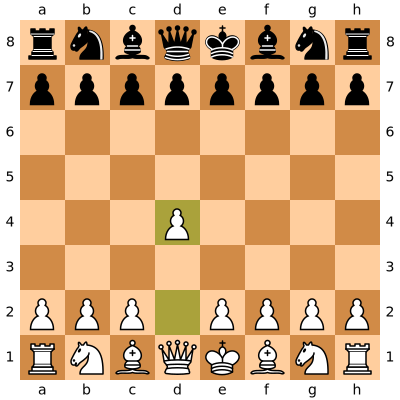

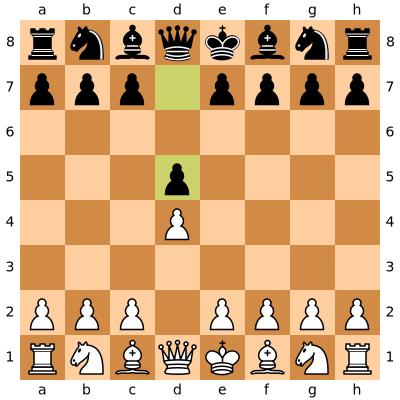

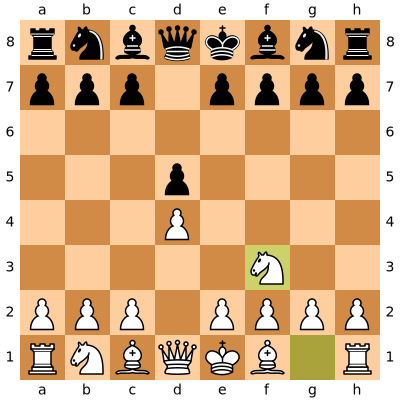

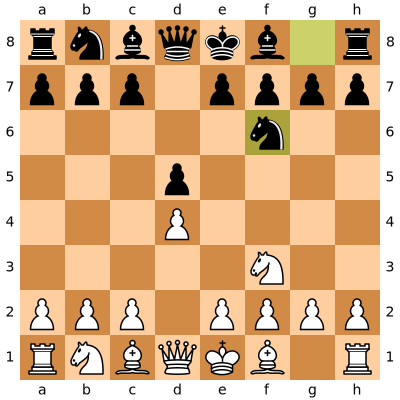

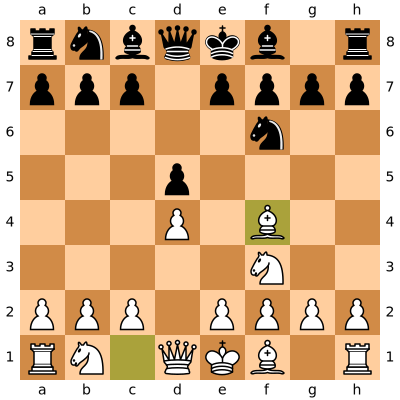

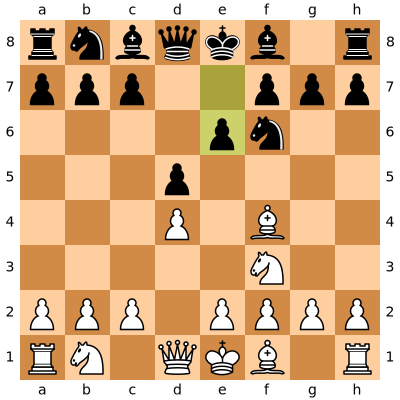

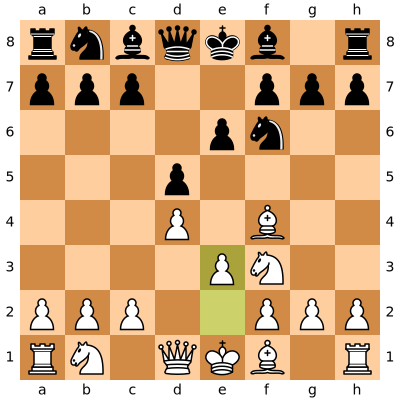

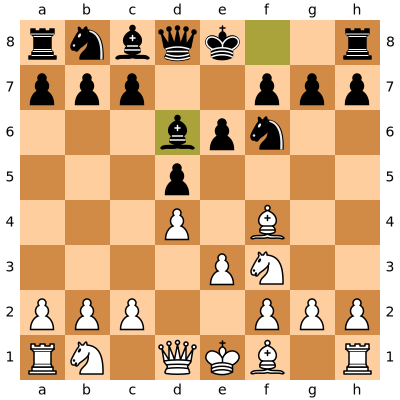

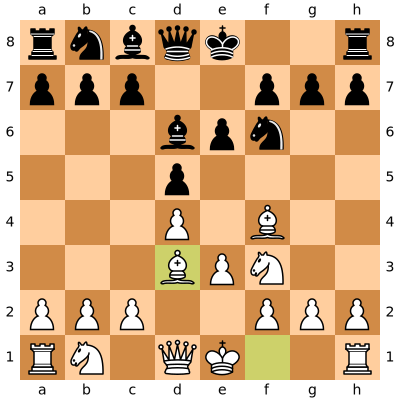

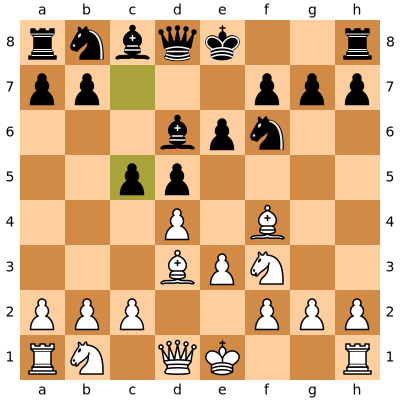

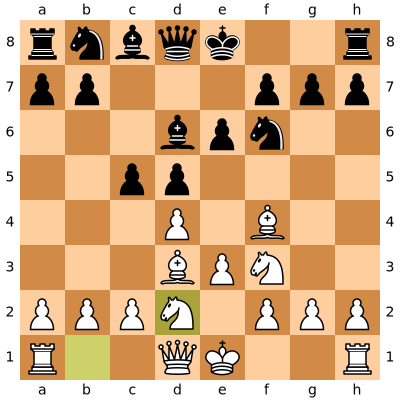

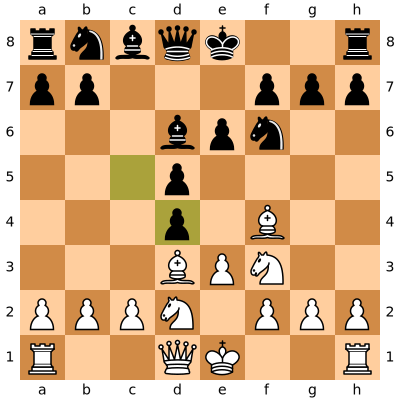

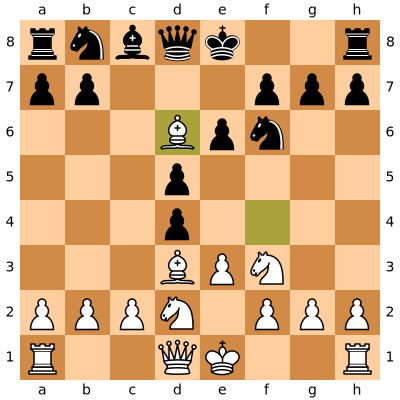

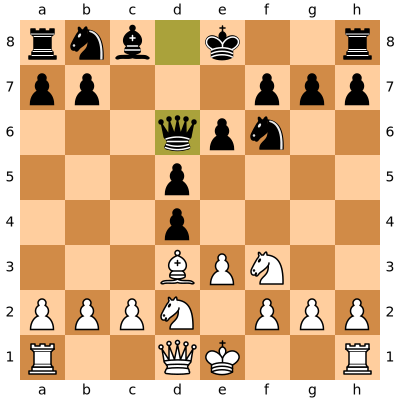

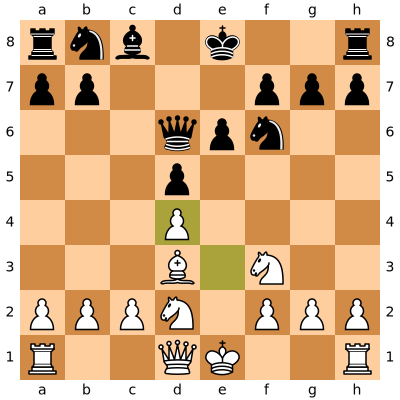

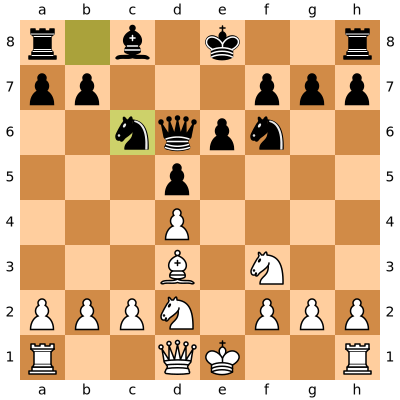

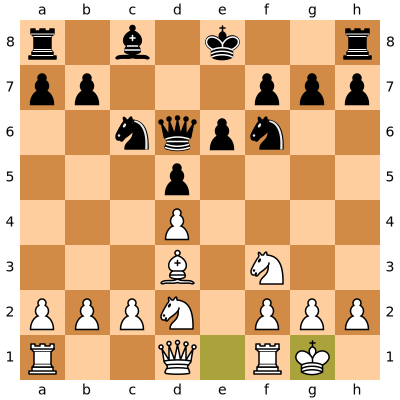

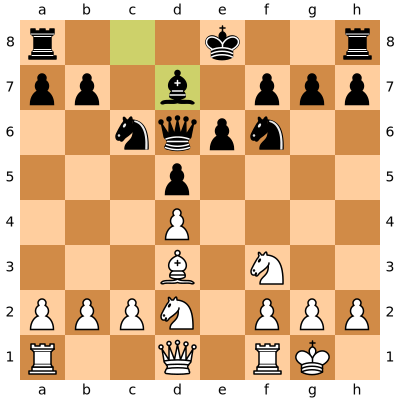

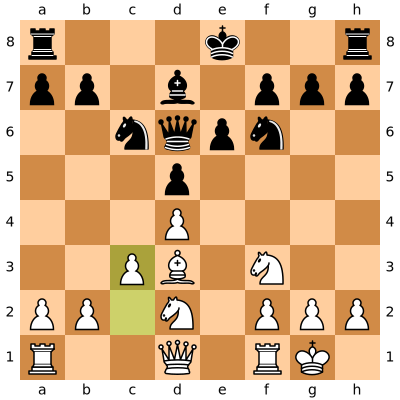

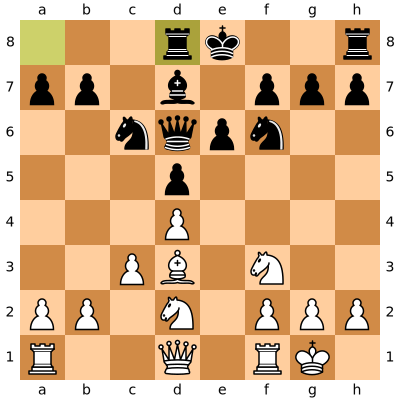

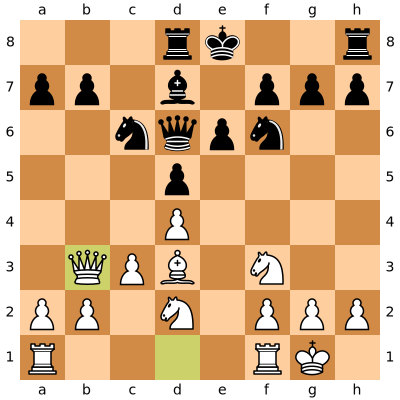

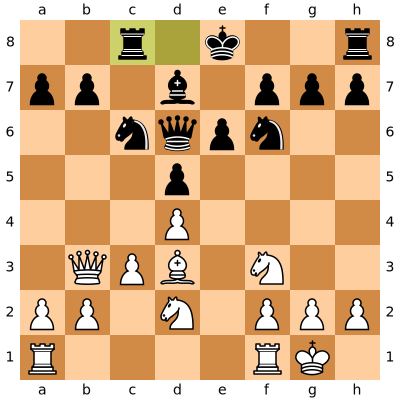

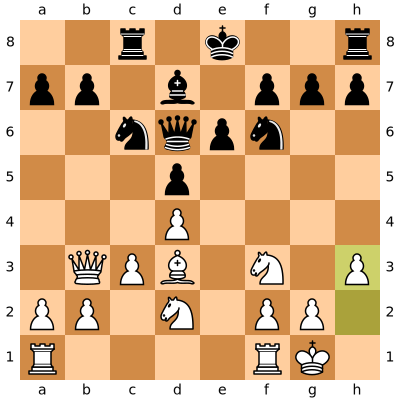

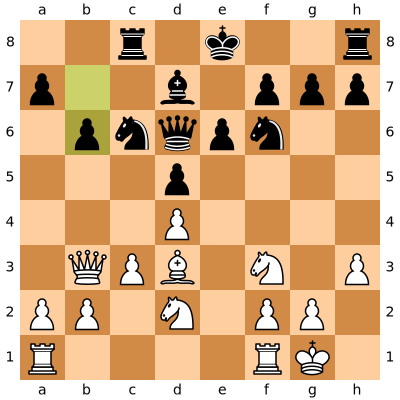

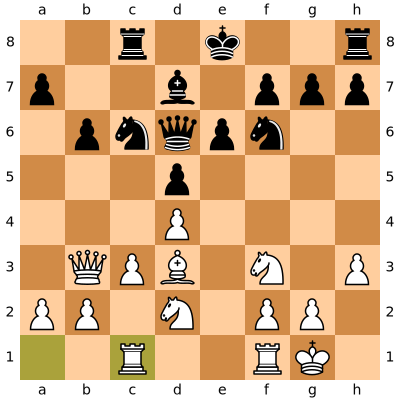

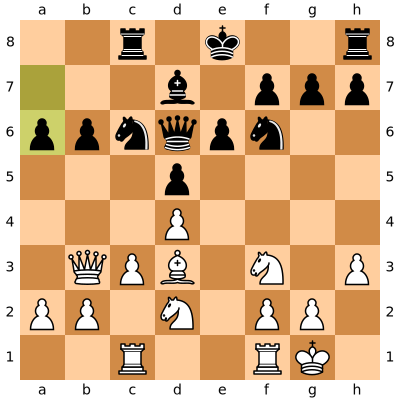

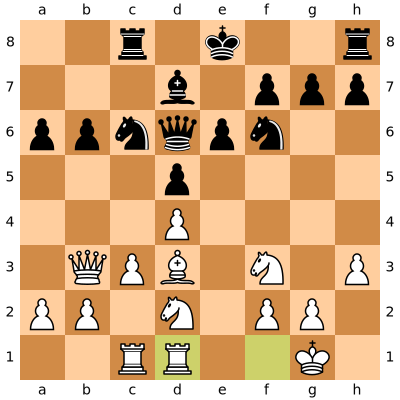

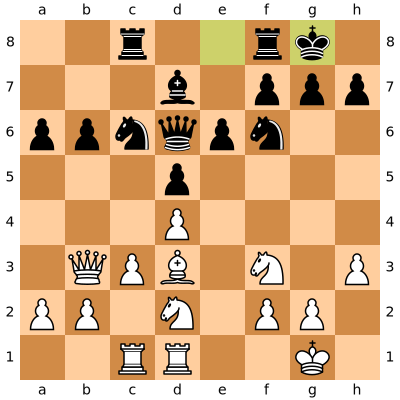

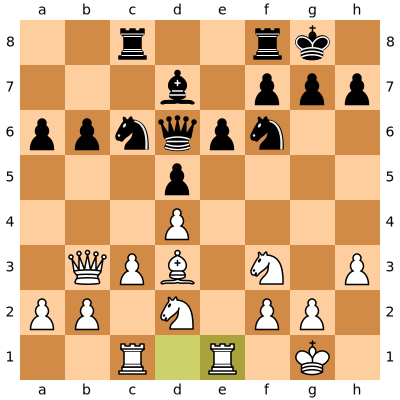

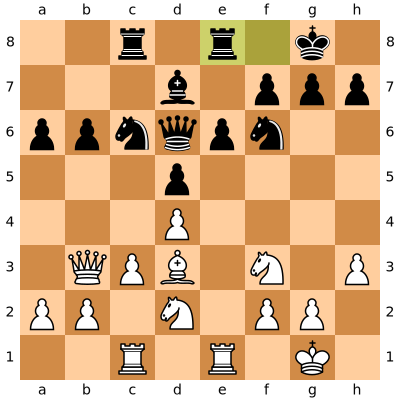

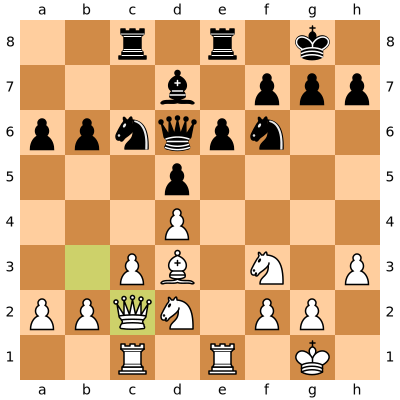

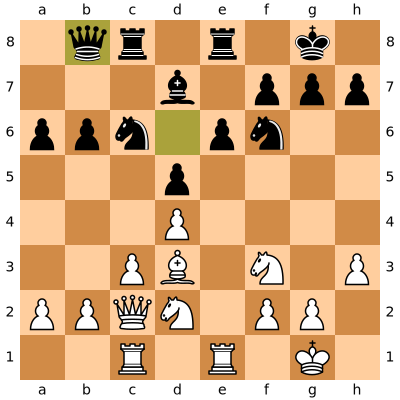

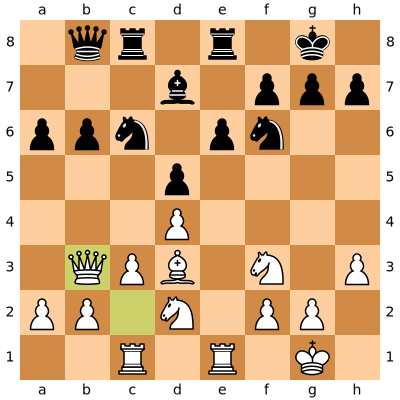

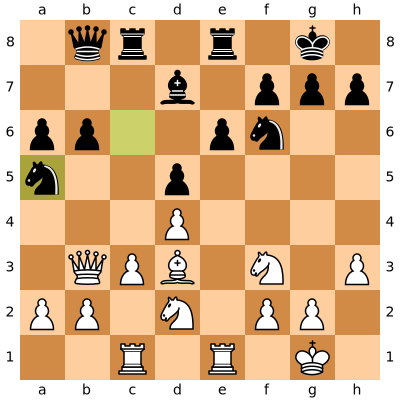

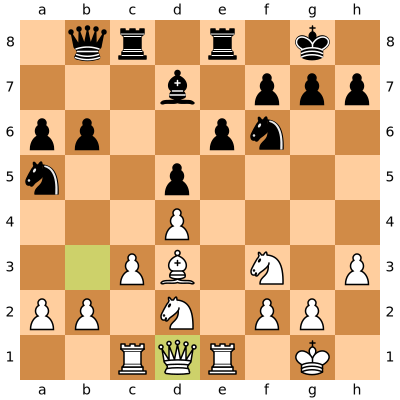

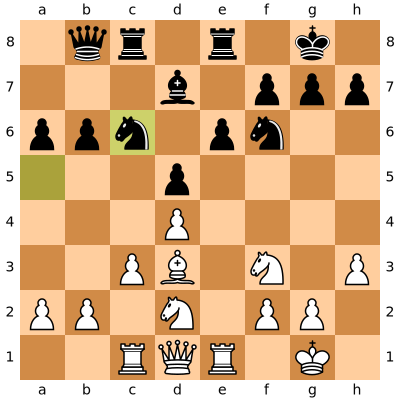

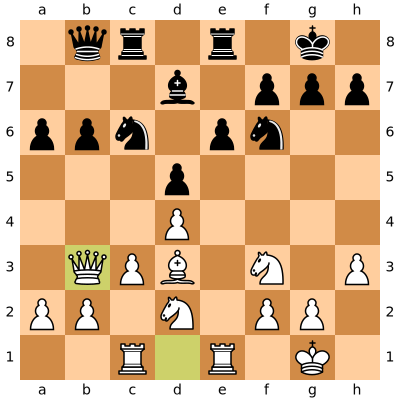

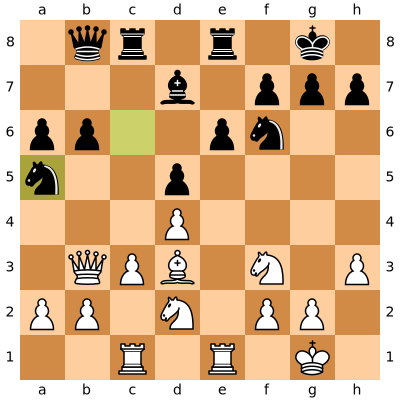

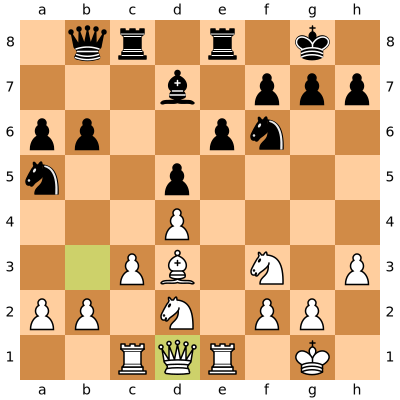

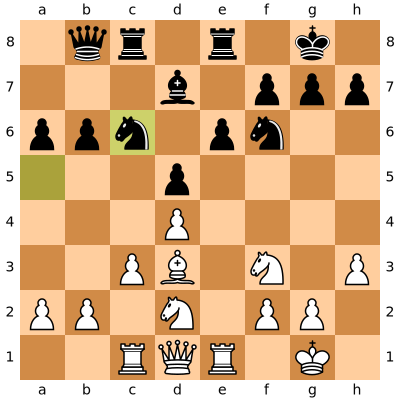

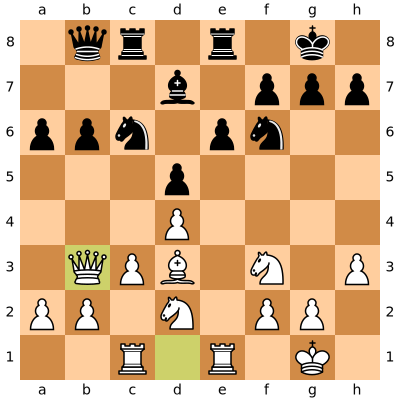

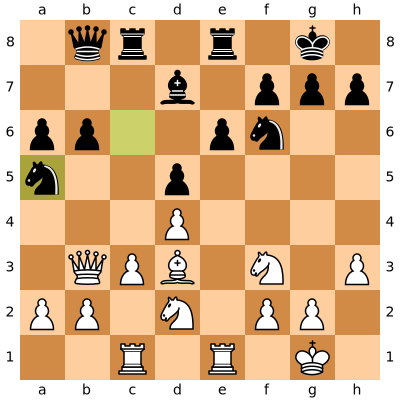

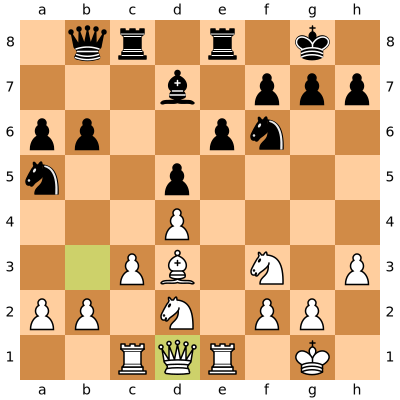

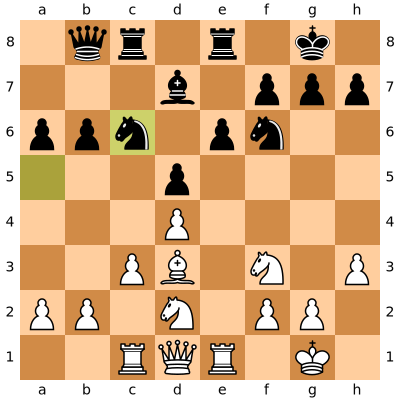

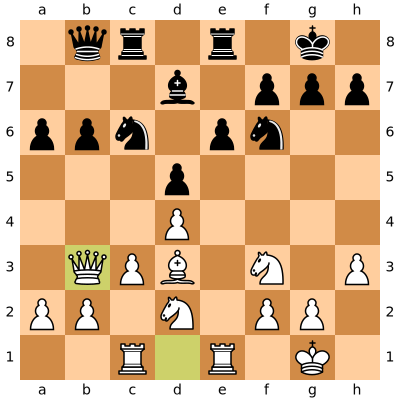

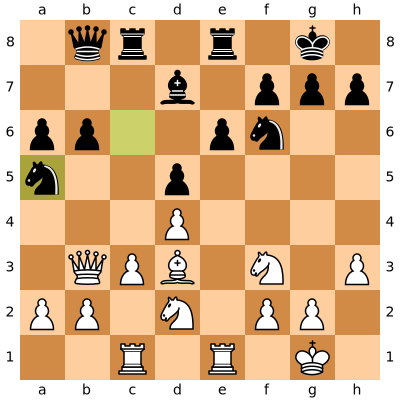

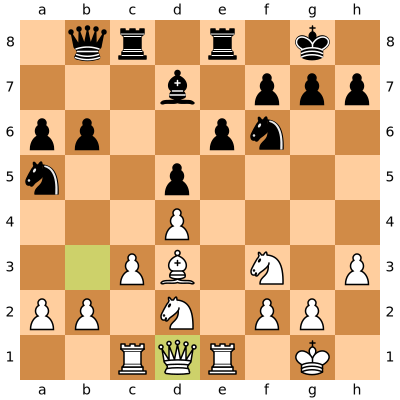

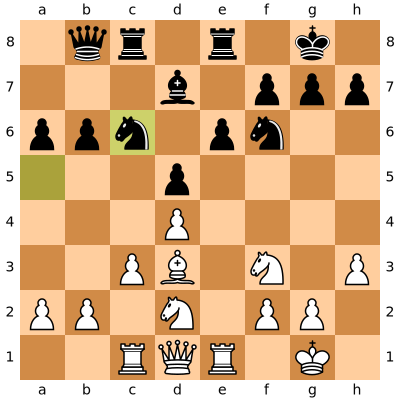

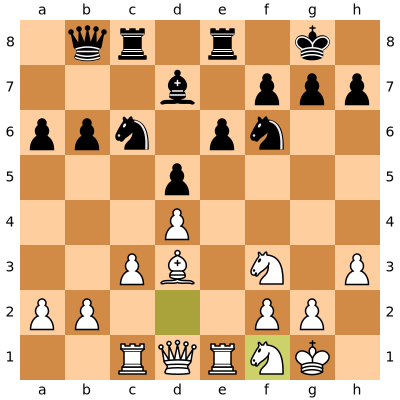

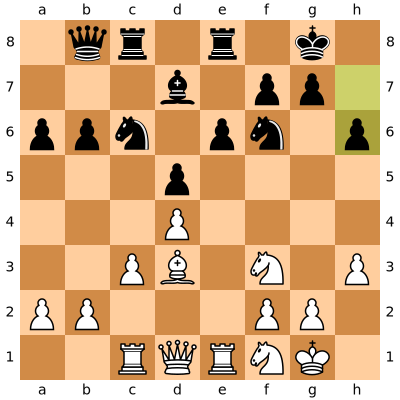

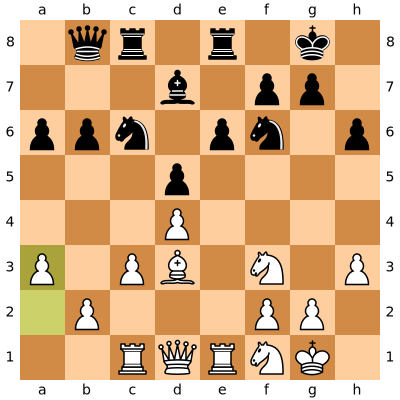

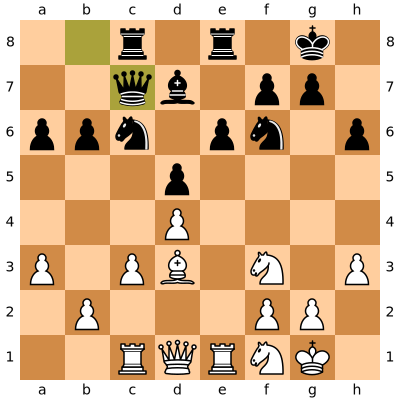

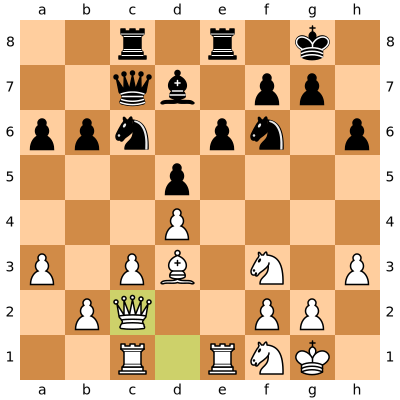

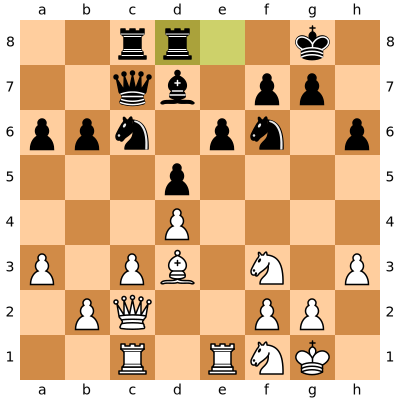

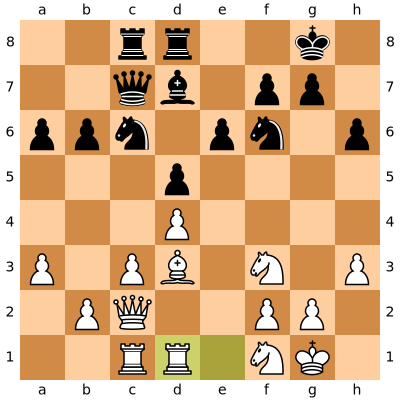

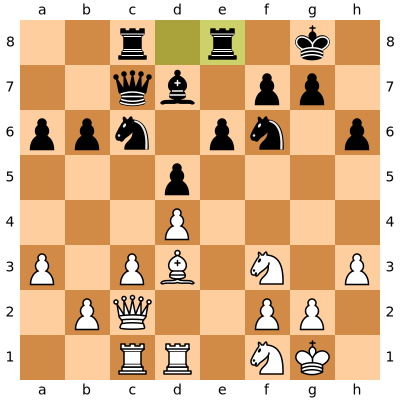

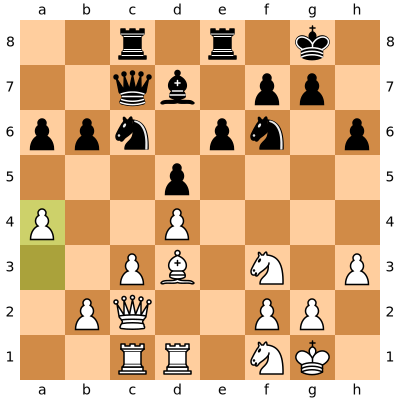

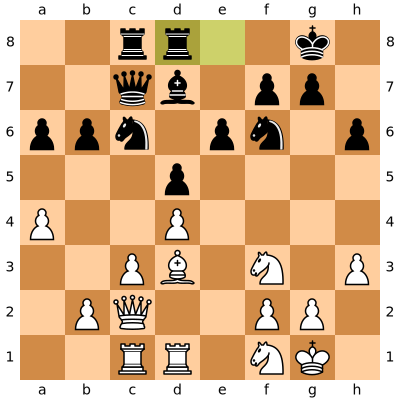

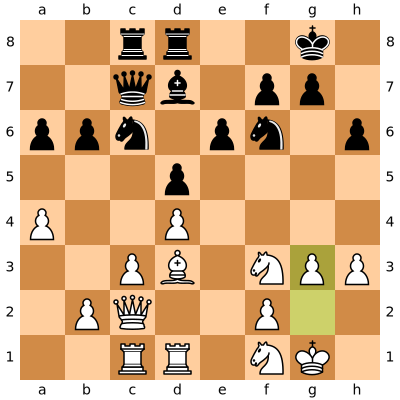

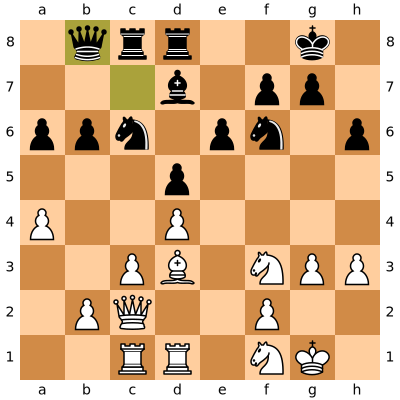

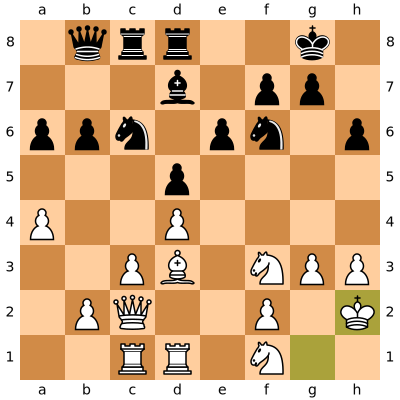

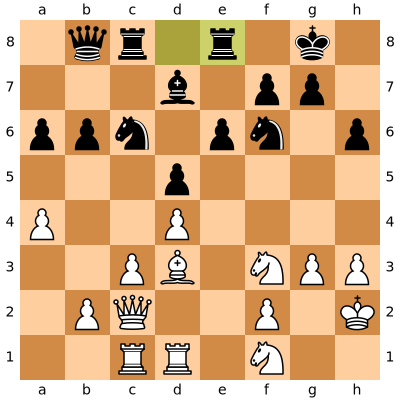

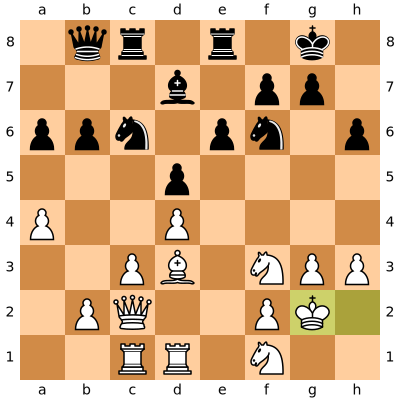

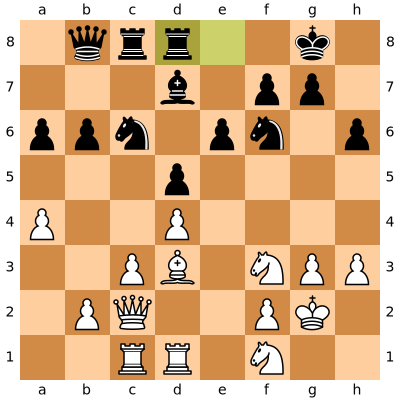

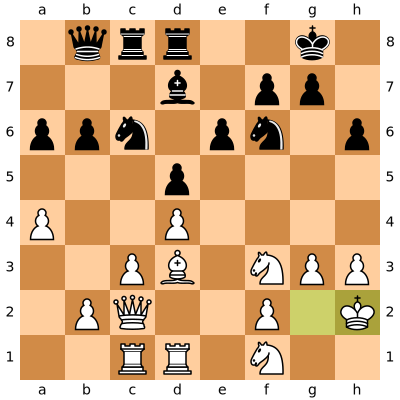

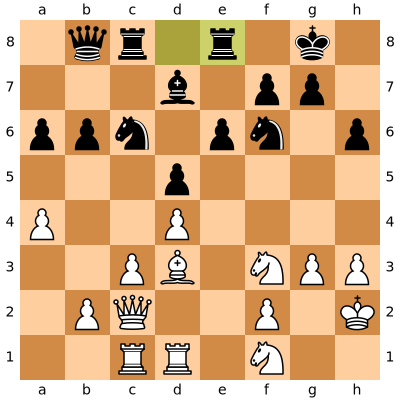

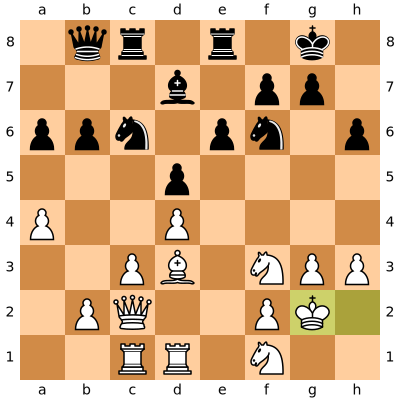

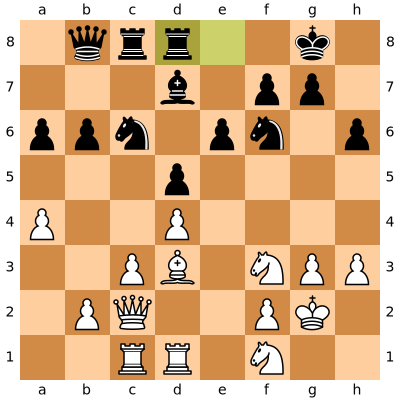

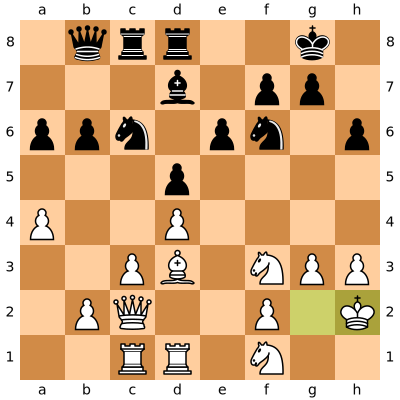

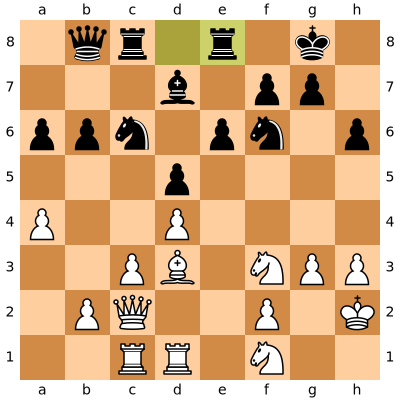

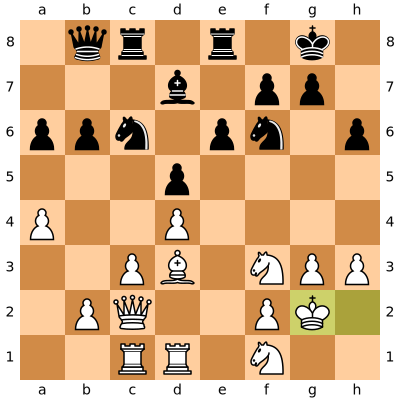

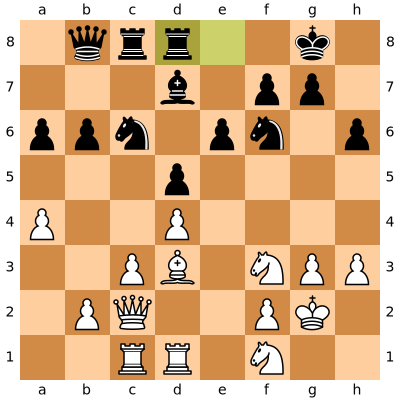

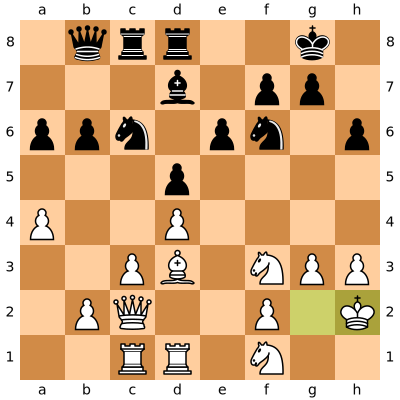

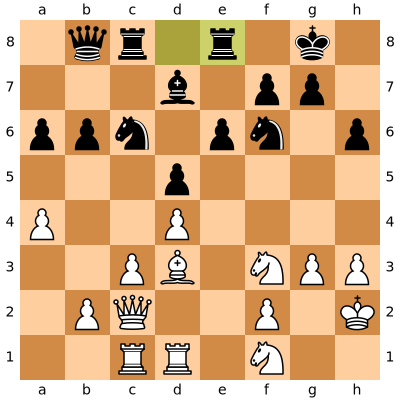

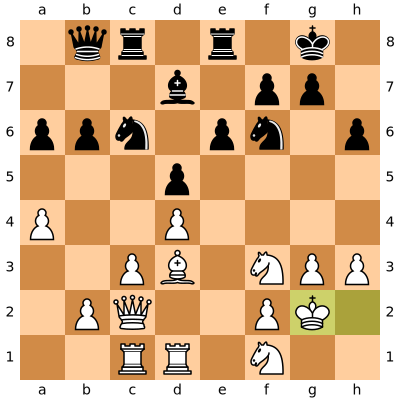

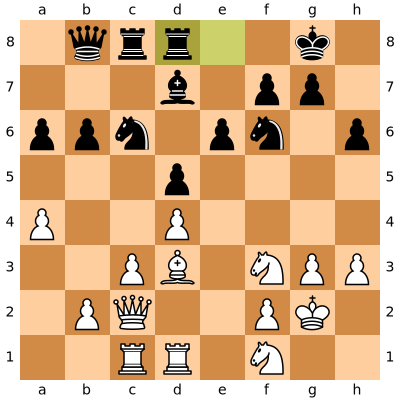

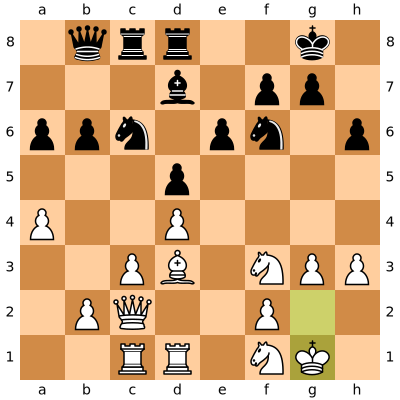

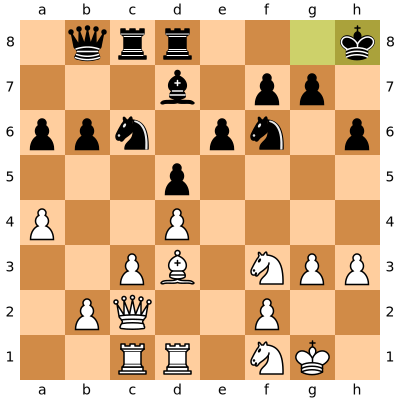

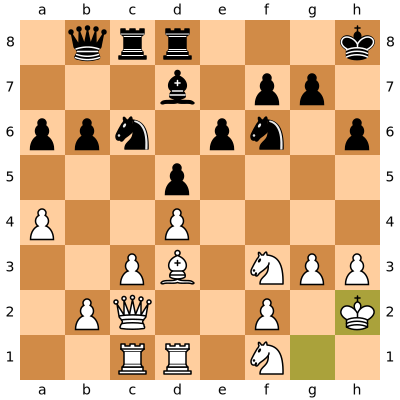

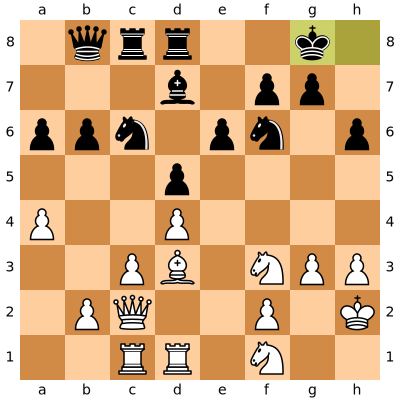

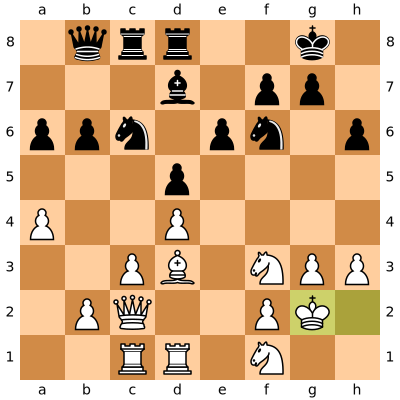

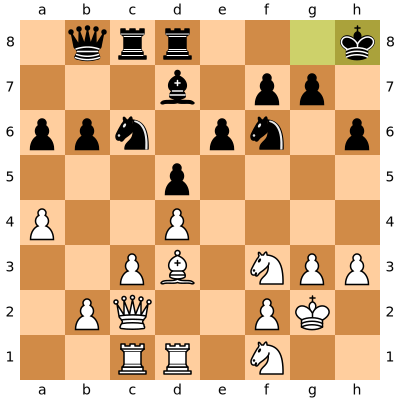

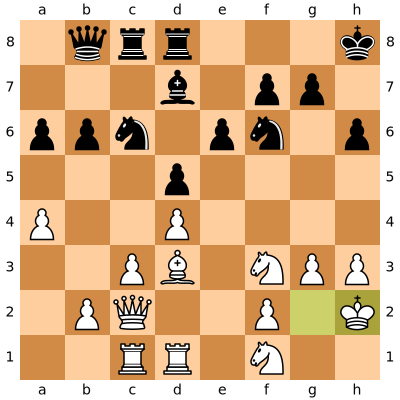

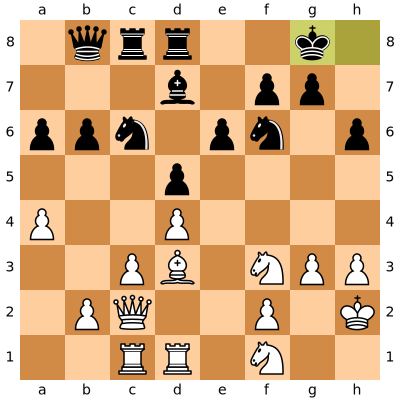

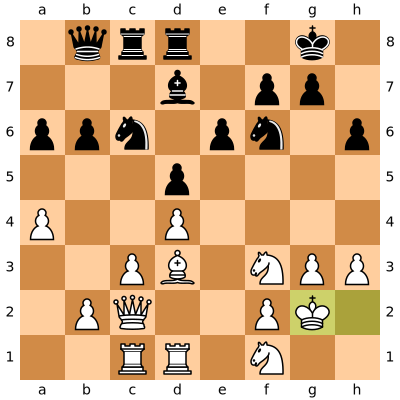

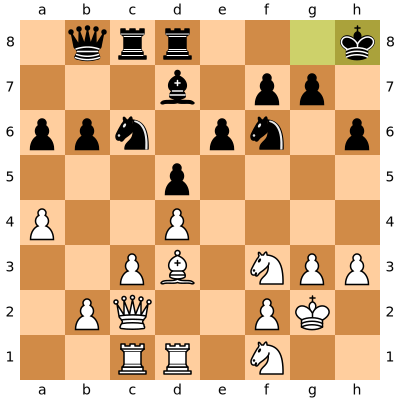

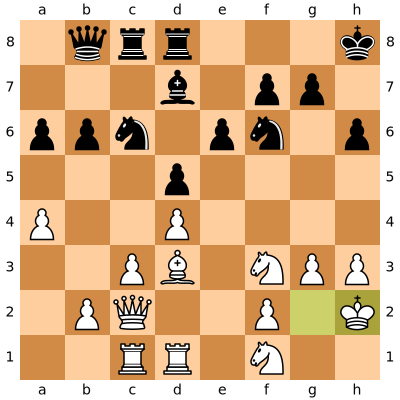

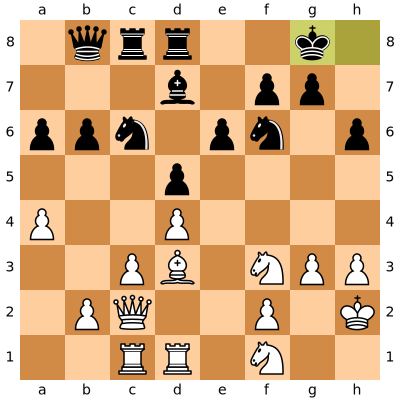

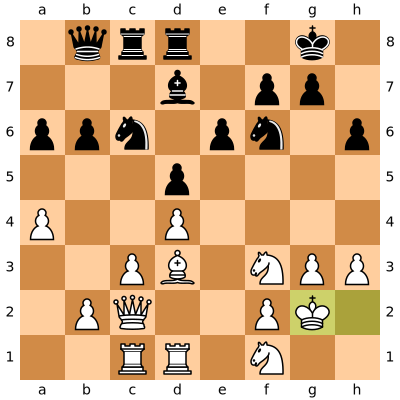

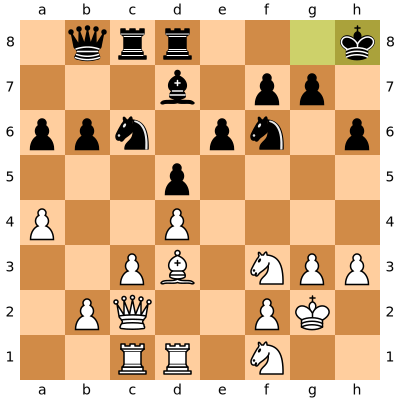

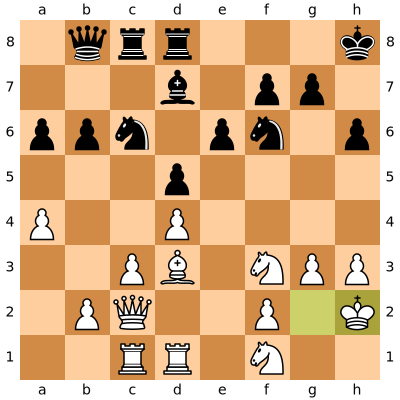

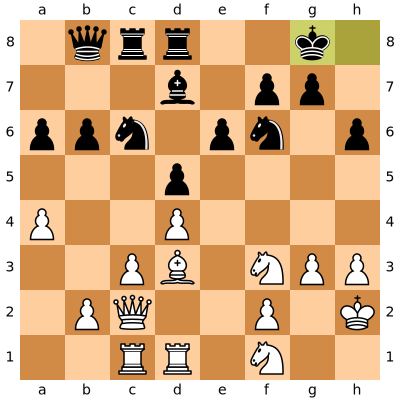

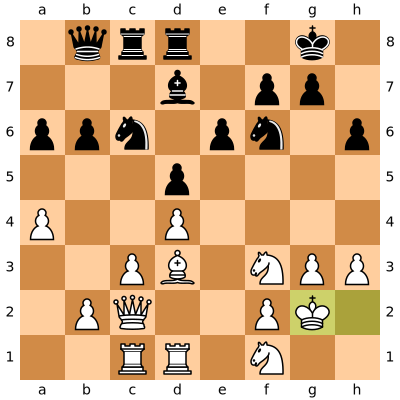

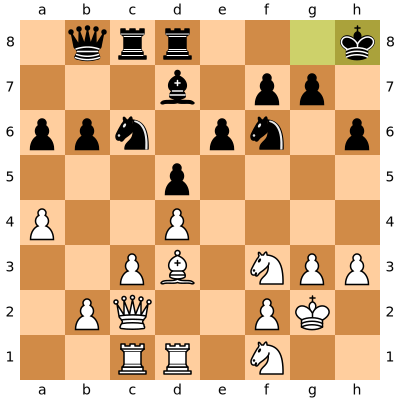

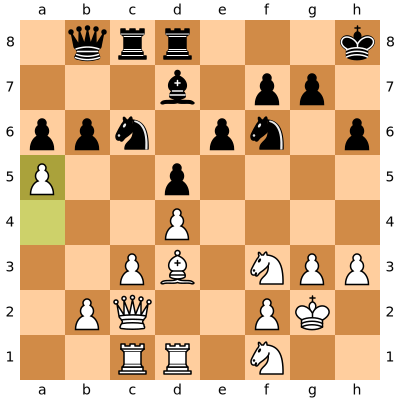

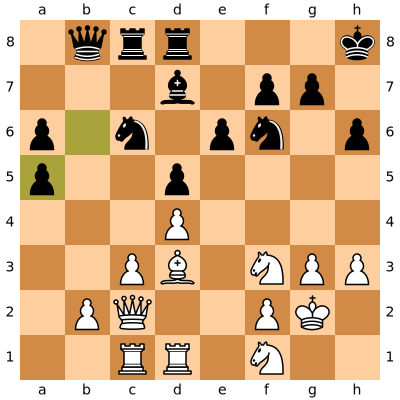

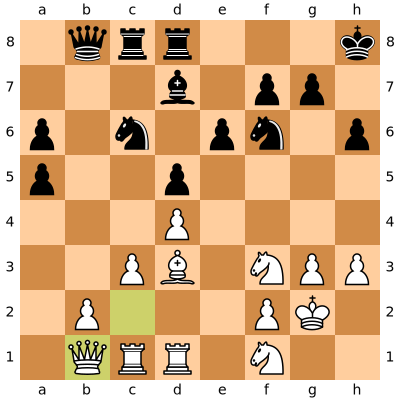

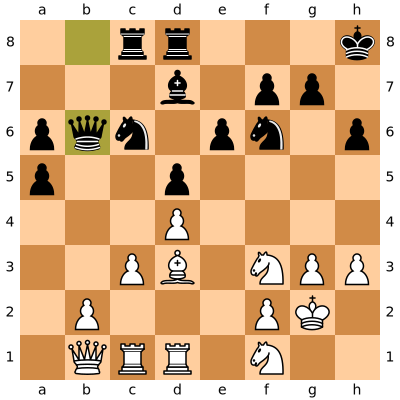

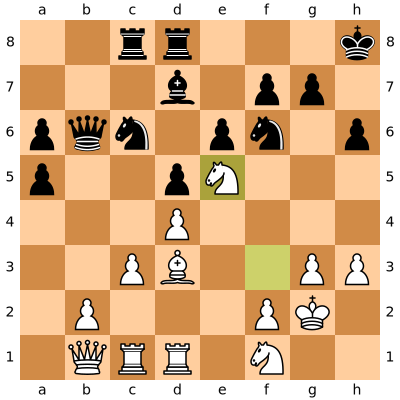

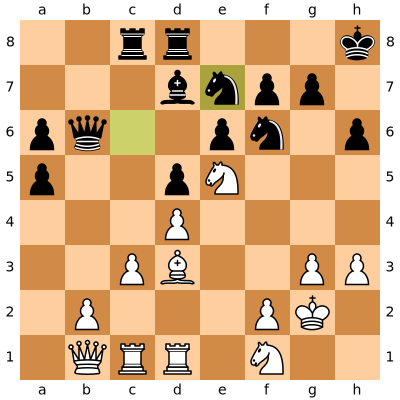

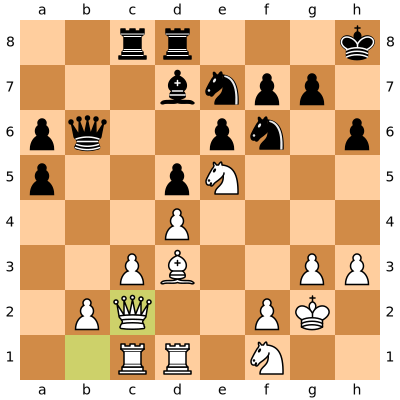

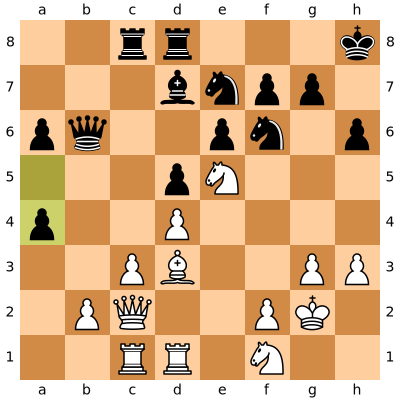

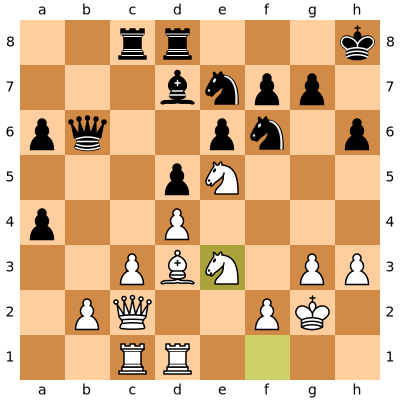

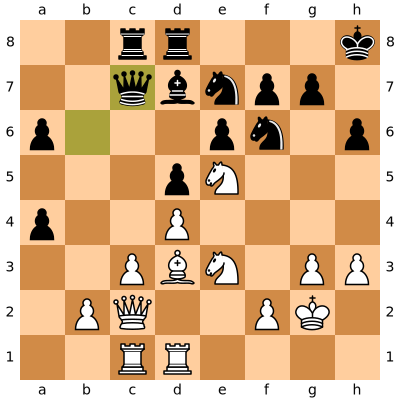

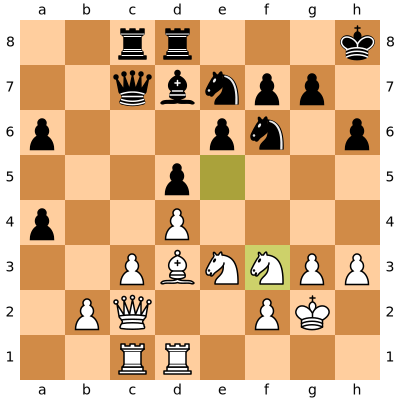

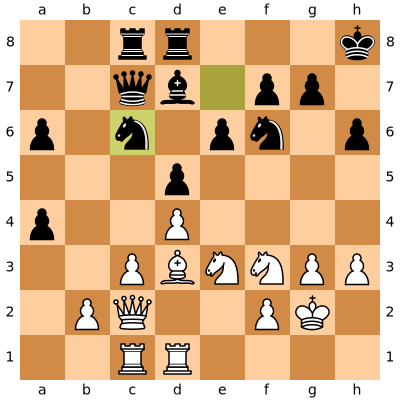

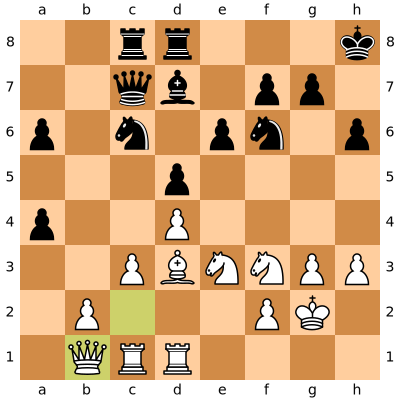

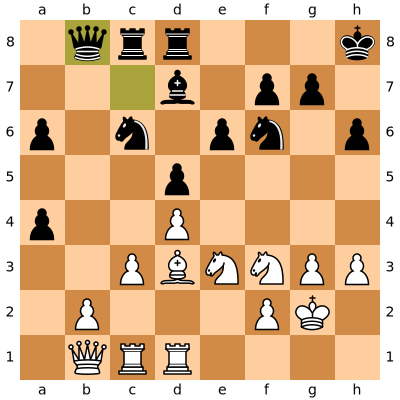

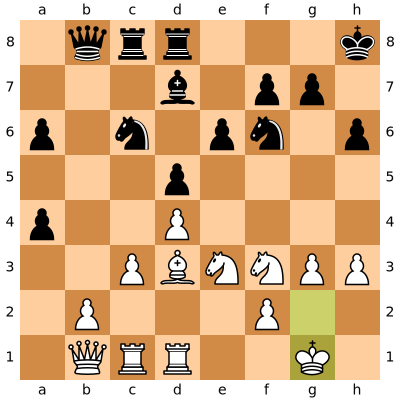

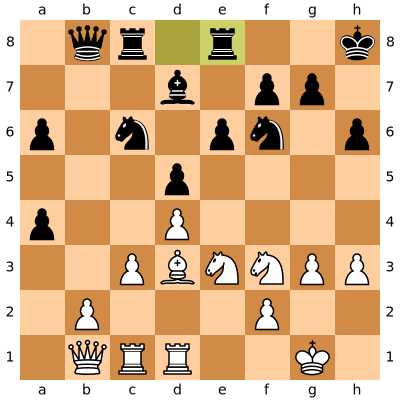

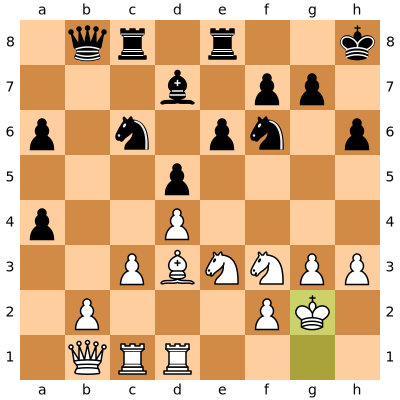

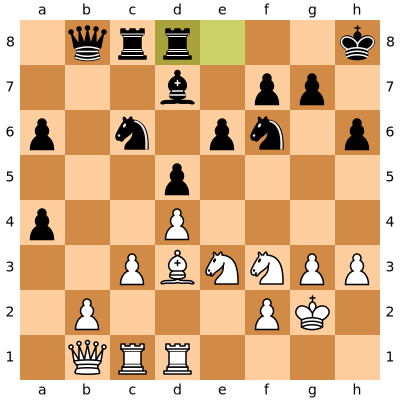

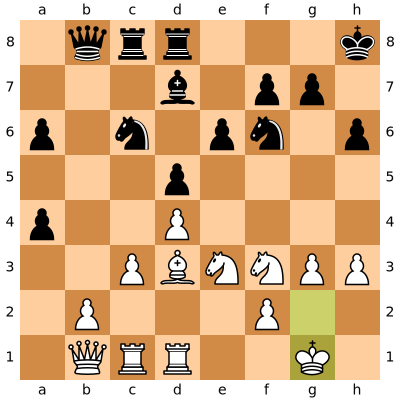

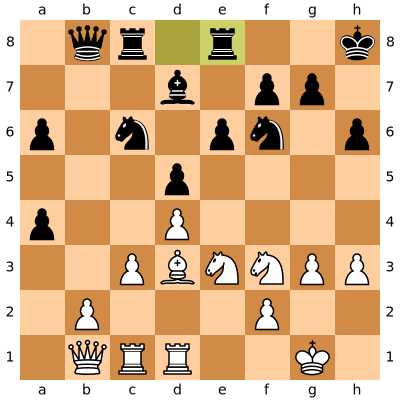

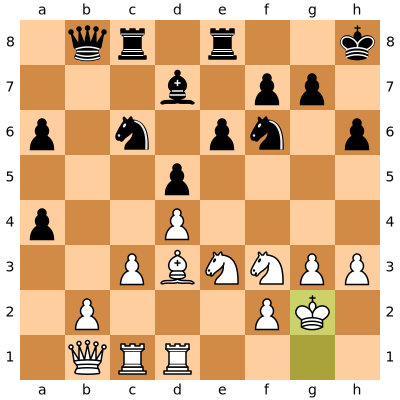

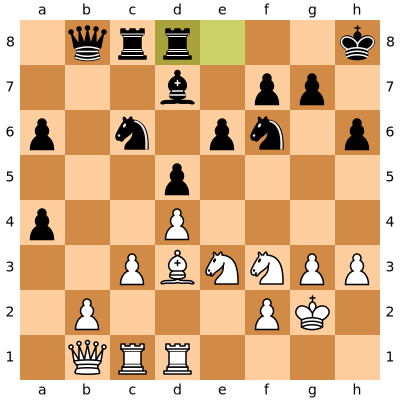

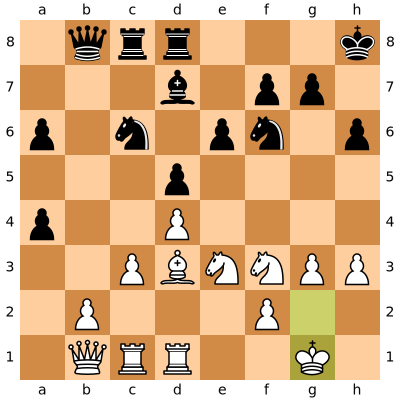

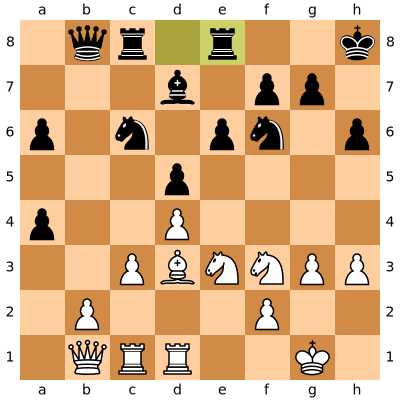

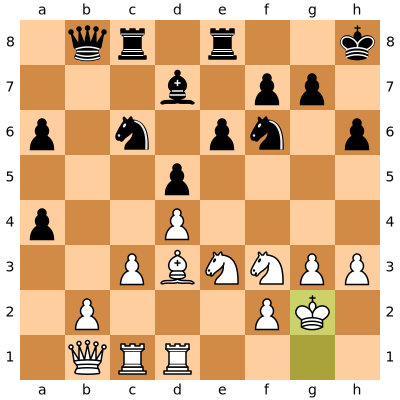

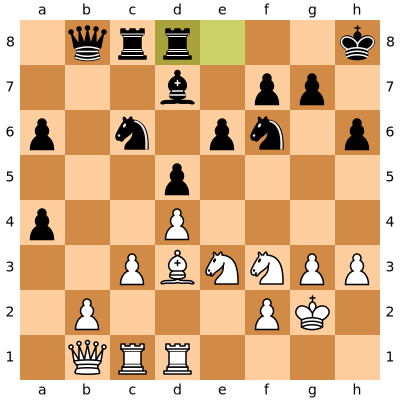

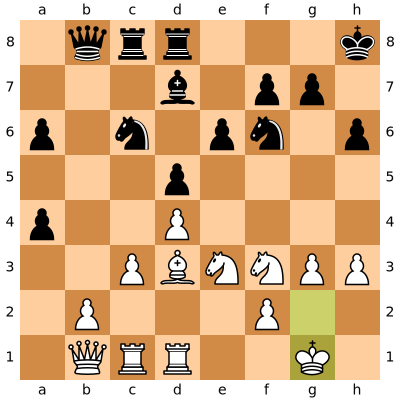

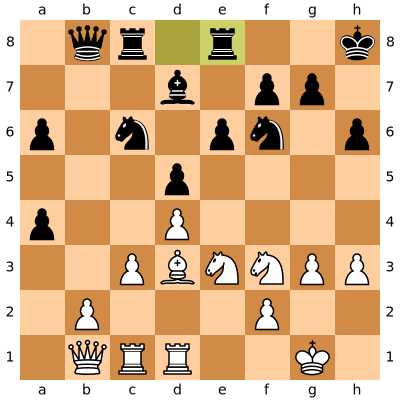

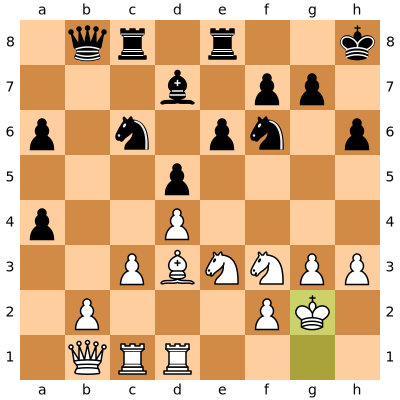

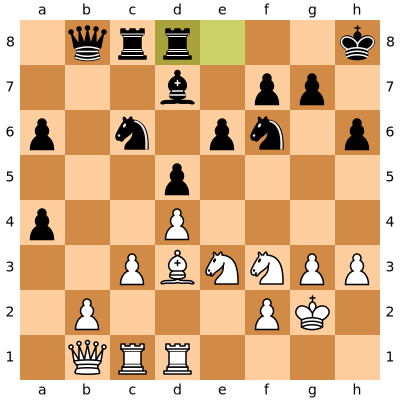

In [7]:
board=chess.Board()
game = chess.pgn.Game()
game.headers["Event"] = "ExamplePFE"
game.headers["Site"] = "Home"
game.headers["Round"] = 1
game.headers["White"] = "SYSTEM"
game.headers["Black"] = "SYSTEM"
movehistory =[]



while not board.is_game_over(claim_draw=False):
    
    if board.turn:
        move , val= chess_engine.choose_move_optimized(board)
        board.push(move)
        display(board)
    else:
        result,val = chess_engine.choose_move_optimized(board)
        movehistory.append(result)
        board.push(result)
        display(board)

game.add_line(movehistory)
game.headers["Result"] = str(board.result(claim_draw=False))
#print(game)
print(game, file=open("C:/Users/king pc/Desktop/code pfe/code/test.pgn", "w"), end="\n\n")
    

In [8]:
print(game)


[Event "ExamplePFE"]
[Site "Home"]
[Date "????.??.??"]
[Round "1"]
[White "SYSTEM"]
[Black "SYSTEM"]
[Result "1/2-1/2"]

1. d5 Nf6 2. e6 Bd6 3. c5 d4 4. Qxd6 Nc6 5. Bd7+ Rd8 6. Rc8# b6 7. a6# O-O 8. Rfe8+ Qb8 9. Na5+ Nc6 10. Na5+ Nc6 11. Na5+ Nc6 12. Na5+ Nc6 13. h6+ Qc7 14. Red8+ Re8 15. Red8+ Qb8 16. Re8+ Rd8 17. Re8+ Rd8 18. Re8+ Rd8 19. Re8+ Rd8 20. Kh8 Kg8 21. Kh8 Kg8 22. Kh8 Kg8 23. Kh8 Kg8 24. Kh8 a5+ 25. Qb6 Ne7+ 26. a4 Qc7+ 27. Nc6 Qb8+ 28. Re8 Rd8+ 29. Re8 Rd8+ 30. Re8 Rd8+ 31. Re8 Rd8+ 1/2-1/2
